<a href="https://colab.research.google.com/github/Minch13r/MachineLearn/blob/main/202235339_%EC%B5%9C%EB%AF%BC%EC%98%81(2%EC%B0%A8).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 라이브러리 임포트 및 버전 확인
---
*   필요한 라이브러리를 임포트하고 버전을 확인
*   Keras를 사용하여 딥러닝 모델을 구축
*   NumPy로 데이터를 처리
*   Matplotlib으로 결과를 시각화


In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

print(f"TensorFlow 버전: {tf.__version__}")
print(f"Keras 버전: {keras.__version__}")

TensorFlow 버전: 2.17.0
Keras 버전: 3.4.1


# 2. MNIST 데이터 로드 및 전처리
---


*   MNIST 데이터를 로드하고 전처리
*   이미지를 정규화하여 모델의 학습을 안정화하고, CNN 모델 입력에 맞게 차원을 추가
*   검증 세트를 분리하여 모델의 일반화 성능을 평가
---

1.   이미지 정규화 (0-255 → 0-1 범위로 변환)


*   학습 안정성: 큰 입력값은 학습 과정에서 기울기 폭발 문제를 일으킬 수 있습니다.

*   수렴 속도: 정규화된 데이터는 더 빠른 학습 수렴을 가능하게 합니다.


*   가중치 업데이트: 모든 특성이 비슷한 스케일을 가지면 가중치 업데이트가 더 균일하게 이루어집니다.

*   메모리 효율성: float32 타입으로 변환하여 메모리 사용을 최적화합니다.





2.   차원 추가 (채널 차원, CNN 입력용)


*   CNN 입력 형식: CNN은 (배치크기, 높이, 너비, 채널) 형태의 4D 텐서를 입력으로 요구합니다.


*   채널 차원: MNIST는 흑백 이미지라서 채널이 1개입니다. 컬러 이미지는 RGB로 3개 채널입니다.

*   호환성: 대부분의 딥러닝 프레임워크가 이 형식을 표준으로 사용합니다.



*   확장성: 나중에 컬러 이미지나 다중 채널 데이터로 확장하기 쉽습니다.

3.    검증 세트 분리


*   모델 평가: 학습 중에 모델의 일반화 성능을 평가할 수 있습니다.


*   과적합 감지: 검증 세트 성능을 통해 과적합 여부를 조기에 발견할 수 있습니다.
*   하이퍼파라미터 튜닝: 검증 세트 성능을 기반으로 모델의 하이퍼파라미터를 조정할 수 있습니다.



*   조기 종료: Early Stopping 등의 기법을 적용할 때 검증 세트 성능을 기준으로 사용합니다.









In [2]:
# MNIST 데이터셋 로드
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

# 이미지 정규화 (0-255 값을 0-1 범위로 변환)
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

# 차원 추가 (채널 차원, CNN 입력용)
train_images = np.expand_dims(train_images, -1)
test_images = np.expand_dims(test_images, -1)

# 검증 세트 분리 (훈련 데이터의 마지막 10,000개를 검증 세트로 사용)
val_images = train_images[-10000:]
val_labels = train_labels[-10000:]
train_images = train_images[:-10000]
train_labels = train_labels[:-10000]

# 데이터 형태 출력
print("훈련 데이터 형태:", train_images.shape)
print("검증 데이터 형태:", val_images.shape)
print("테스트 데이터 형태:", test_images.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
훈련 데이터 형태: (50000, 28, 28, 1)
검증 데이터 형태: (10000, 28, 28, 1)
테스트 데이터 형태: (10000, 28, 28, 1)


# 3. 모델 구축
---


*   CNN(합성곱) 모델을 생성
*   컨볼루션 층, 배치 정규화, 최대 풀링, 드롭아웃 등을 사용하여 모델의 성능을 향상시키고 과적합을 방지
*   Adam 옵티마이저와 적절한 손실 함수를 사용하여 모델을 컴파일

---


1.   필터 개수 증가 이유


*   계층적 특징 추출: 상위 층으로 갈수록 더 복잡한 특징을 추출하기 위해 필터 수를 증가시킵니다.
*   연산량 균형: 초기 층에서는 적은 수의 필터로 기본적인 특징을 추출하고, 상위 층에서 더 많은 필터로 세부적인 특징을 포착합니다.
*   메모리 효율성: 첫 층에서 너무 많은 필터를 사용하면 메모리 사용량이 급증할 수 있습니다.


2.   ReLu 활성화 함수 사용 이유
*   비선형성 도입: 복잡한 패턴을 학습할 수 있게 합니다.
*   기울기 소실 문제 완화: 양의 입력에 대해 기울기가 항상 1이므로, 깊은 신경망에서도 효과적으로 학습이 가능합니다.

3.  sparse_categorical_crossentropy 사용 이유
*   MNIST는 0-9까지의 10개 클래스를 분류하는 정수 분류 문제이기 때문에 사용

4. Dropout(0.25, 0.5) 사용 이유
*   과적합 방지: 학습 중 무작위로 뉴런을 비활성화하여 모델의 일반화 능력을 향상시킵니다.
*   앙상블 효과: 여러 서브 네트워크의 평균을 내는 효과가 있습니다.



In [3]:
def create_model():
    model = keras.Sequential([
        # 첫 번째 컨볼루션 층: 32개의 3x3 필터, ReLU 활성화
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        keras.layers.BatchNormalization(),  # 배치 정규화로 학습 안정화
        keras.layers.MaxPooling2D((2, 2)),  # 최대 풀링으로 특성 맵 크기 축소
        keras.layers.Dropout(0.25),  # 과적합 방지를 위한 드롭아웃

        # 두 번째 컨볼루션 층: 64개의 3x3 필터
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Dropout(0.25),

        # 세 번째 컨볼루션 층: 64개의 3x3 필터
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Flatten(),  # 2D 특성 맵을 1D 벡터로 평탄화
        keras.layers.Dropout(0.5),

        # 완전 연결 층
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation='softmax')  # 출력층: 10개 클래스에 대한 확률 분포
    ])

    # 모델 컴파일: Adam 옵티마이저, 학습률 0.001
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = create_model()
model.summary()  # 모델 구조 요약 출력


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 26, 26, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 11, 11, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 3, 3, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 132,042 (515.79 KB)

 Trainable params: 131,466 (513.54 KB)

 Non-trainable params: 576 (2.25 KB)

# 4. 콜백 함수 정의
---


*   학습 과정을 제어하고 최적화하기 위한 콜백 함수들을 정의
*   Early Stopping은 과적합을 방지
*   학습률 감소는 학습을 미세 조정
*   모델 체크포인트는 최고 성능의 모델을 저장
---


1.   Early Stopping (조기 종료) 사용 이유


*   과적합 방지: 모델이 훈련 데이터에 과도하게 맞춰지는 것을 막습니다.
*   계산 자원 절약: 불필요한 추가 학습을 방지하여 시간과 컴퓨팅 리소스를 절약합니다.
*   최적 성능 유지: 검증 성능이 가장 좋았을 때의 모델을 저장합니다.


2.   ReduceLROnPlateau (학습률 감소) 사용 이유
*   학습 안정화: 학습이 정체될 때 학습률을 낮춰 더 세밀한 최적화를 가능하게 합니다.
*   지역 최적점 탈출: 큰 학습률로 인한 진동을 줄이고, 더 나은 최적점을 찾을 수 있게 합니다.
*   자동 학습률 조정: 수동으로 학습률을 조정할 필요 없이 자동으로 관리됩니다.



In [6]:
# Early Stopping: 검증 손실이 10에폭 동안 개선되지 않으면 학습 중단
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# 학습률 감소: 검증 손실이 5에폭 동안 개선되지 않으면 학습률을 0.2배로 감소
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)

# 모델 체크포인트: 가장 좋은 검증 정확도를 가진 모델 저장
model_checkpoint = keras.callbacks.ModelCheckpoint(
    'best_model.keras',
    save_best_only=True,
    monitor='val_accuracy'
)

# 5. 모델 학습
---


*   모델 학습
*   배치 크기, 에폭 수, 검증 데이터, 콜백 함수 등을 지정하여 학습을 제어합




In [7]:
# 모델 학습 실행
history = model.fit(
    train_images, train_labels,
    epochs=50,  # 최대 50 에폭 학습
    batch_size=128,  # 배치 크기 128
    validation_data=(val_images, val_labels),  # 검증 데이터 지정
    callbacks=[early_stopping, reduce_lr, model_checkpoint],  # 콜백 함수 적용
    verbose=1  # 학습 과정 출력
)

Epoch 1/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 70s 168ms/step - accuracy: 0.7144 - loss: 0.9500 - val_accuracy: 0.1927 - val_loss: 4.1446 - learning_rate: 0.0010
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 76s 154ms/step - accuracy: 0.9501 - loss: 0.1600 - val_accuracy: 0.9806 - val_loss: 0.0663 - learning_rate: 0.0010
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 83s 157ms/step - accuracy: 0.9665 - loss: 0.1090 - val_accuracy: 0.9856 - val_loss: 0.0470 - learning_rate: 0.0010
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 82s 156ms/step - accuracy: 0.9729 - loss: 0.0850 - val_accuracy: 0.9874 - val_loss: 0.0420 - learning_rate: 0.0010
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 60s 153ms/step - accuracy: 0.9767 - loss: 0.0776 - val_accuracy: 0.9885 - val_loss: 0.0392 - learning_rate: 0.0010
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 83s 156ms/step - accuracy: 0.9794 - loss: 0.0672 - val_accuracy: 0.9899 - val_loss: 0.0336 - learning_rate: 0.0010
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 82s 155ms/step - accuracy: 0.9

# 6. 학습 과정 시각화
---


*   학습 과정에서의 정확도와 손실 변화를 시각화
*   모델의 학습 진행 상황과 과적합 여부를 파악 가능



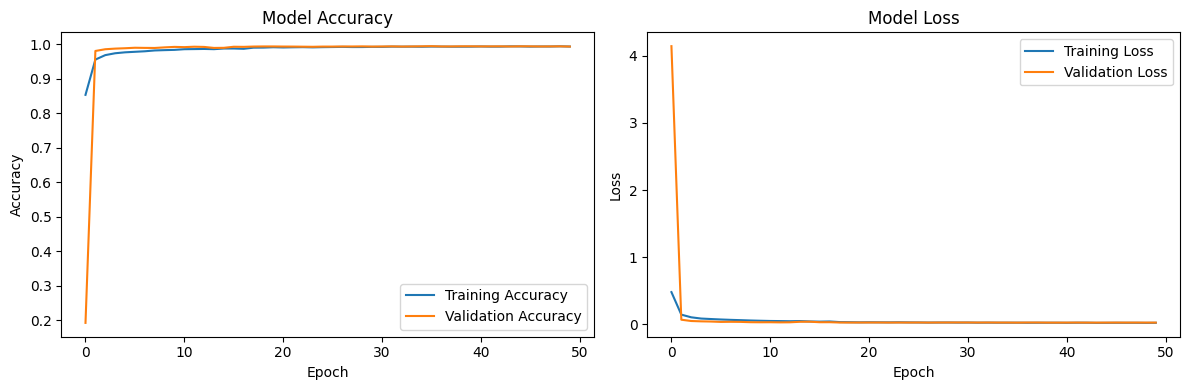

In [8]:
plt.figure(figsize=(12, 4))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 7. 모델 평가 및 결과 출력
---


*   저장된 최고 성능 모델을 로드하고 검증 세트와 테스트 세트에 대한 성능을 평가
*   모델의 일반화 성능을 확인하고, 과적합 여부를 판단
*   best_model.keras는 추후 202235339최민영.keras라는 파일명으로 바뀔 예정



In [12]:
# 최고 성능 모델 로드
best_model = keras.models.load_model('best_model.keras')

# 검증 세트와 테스트 세트에 대한 성능 평가
val_loss, val_accuracy = best_model.evaluate(val_images, val_labels)
test_loss, test_accuracy = best_model.evaluate(test_images, test_labels)

# 결과 출력
print(f"검증 세트 손실: {val_loss:.4f}")
print(f"검증 세트 정확도: {val_accuracy:.4f}")
print(f"테스트 세트 손실: {test_loss:.4f}")
print(f"테스트 세트 정확도: {test_accuracy:.4f}")
print(f"손실 차이: {abs(val_loss - test_loss):.4f}")
print(f"정확도 차이: {abs(val_accuracy - test_accuracy):.4f}")

print("최고 성능 모델이 'best_model.keras'로 저장되었습니다.")

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9948 - loss: 0.0210
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9942 - loss: 0.0211
검증 세트 손실: 0.0228
검증 세트 정확도: 0.9945
테스트 세트 손실: 0.0179
테스트 세트 정확도: 0.9952
손실 차이: 0.0050
정확도 차이: 0.0007
최고 성능 모델이 'best_model.keras'로 저장되었습니다.
